# Retina Net Implementation for Pneumonia Detection

In [1]:
# Clone the git for RetinaNet implementation
!git clone "https://github.com/fizyr/keras-retinanet.git"

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 5446 (delta 4), reused 1 (delta 0), pack-reused 5436
Receiving objects: 100% (5446/5446), 13.32 MiB | 34.71 MiB/s, done.
Resolving deltas: 100% (3642/3642), done.


In [2]:
# Install the pre-requisites and import required libraries
!pip install pydicom
import glob, pylab, pandas as pd
import numpy as np
import matplotlib.image as image
import pydicom as dcm
#from skimage.transform import resize

     |████████████████████████████████| 35.1MB 101kB/s 


In [3]:
#Mount drive to access the files in google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd keras-retinanet

/content/keras-retinanet


In [5]:
# Install the required directory
!pip install .

Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169825 sha256=ffff28672cb039a6ddc183d0924d79f8ca4f5e6eaad9b029fadc6100a65ef06b
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13344 sha256=1e987661e458b89957fba6dee31f88fd087b375a18ec1472a58c572d34351b47
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [6]:
# Compile the script using the setup file
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [0]:
# Read the labels file
detailed_class_df = pd.read_csv('/content/drive/My Drive/GL Capstone Project/Dataset/stage_2_train_labels.csv')

In [0]:
# Filter records with pnuemonia cases
detailed_class_df=detailed_class_df[detailed_class_df['Target']==1]

In [0]:
# Group images with different bounding boxes
def parse_data(df):
    extract_box = lambda row: [row['x'], row['y'], row['width'], row['height']]
    parsed = {}
    for n, row in df.iterrows():
        
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'boxes': []}
        parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [0]:
# Convert dcm file to JPEG for usage in RetinaNet
def converttoJpeg(patientId):
    dicom_file = dcm.read_file(inp_path+patientId+'.dcm')
    dicom_array = dicom_file.pixel_array
    #image_array = resize(dicom_array, (512, 512), mode= 'constant', anti_aliasing=True)
    image.imsave(out_path+patientId+".jpg", dicom_array)

In [0]:
# Get the first 4000 records for training
train_dict=parse_data(detailed_class_df.head(4000))

In [0]:
# Remove CSV files in case they are already available
#import os
#os.remove("annotate.csv")
#os.remove("class.csv")

In [0]:
#set path to the file location
out_path = '/content/drive/My Drive/GL Capstone Project/Dataset/JPEG/'
inp_path = '/content/drive/My Drive/GL Capstone Project/Dataset/stage_2_train_images/'

In [0]:
# Create annotation file for the images of the format image_path,x1,y1,x2,y3,'pnenumonia'
# Create class label file of the format 'pneumonia',0
for patient_id in train_dict.keys():
    box =train_dict[patient_id]['boxes']
    #converttoJpeg(patient_id)
    path = out_path+patient_id+".jpg"
    for j in range(len(box)):
      x1 = int(box[j][0])             #Upper lef 
      x2 = int(box[j][0] + box[j][2])
      y1 = int(box[j][1])
      y2 = int(box[j][1] + box[j][3]) #Upper left y1 + height  
      towrite = str(path+ "," + str(x1) + ","+ str(y1)+","+ str(x2)+","+ str(y2)+",Pneumonia")
      with open("annotate.csv", "a") as wr:
            wr.write(towrite)
            wr.write('\n')
      with open("class.csv", "w") as wr:
            towrite = str("Pneumonia,0")
            wr.write(towrite)

In [0]:
# Load pre-trained model weights
import urllib
#PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
PRETRAINED_MODEL = './snapshots/resnet50_csv_10.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

('./snapshots/resnet50_csv_10.h5', <http.client.HTTPMessage at 0x7ff7dee5c080>)

In [15]:
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 3.5MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 32 --steps 100 --epochs 10 csv annotate.csv class.csv

Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 9) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((9,) vs (720,)).
  weight_values[i].shape))
2020-01-19 09:58:42.782841: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-01-19 09:58:42.839452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-01-19 09:58:42.840006: I tensorflow/co

In [0]:
!pwd

/content/keras-retinanet


In [0]:
!keras_retinanet/bin/evaluate.py  csv annotate.csv class.csv /content/keras-retinanet/snapshots/resnet50_csv_10.h5 --convert-model

Using TensorFlow backend.
Loading model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2020-01-24 18:06:54.522637: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-01-24 18:06:54.527445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-01-24 18:06:54.528036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-01-24 18:06:54.528293: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-01-24 18:06:54.532537: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

In [0]:
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import cv2

In [37]:
model_path='/content/keras-retinanet/snapshots/resnet50_csv_10.h5'
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


In [0]:
THRES_SCORE = 0.3


In [0]:
def draw_image(patient_id):
  pred_box=[]
  actual_box=[]
  file_path = out_path + patient_id+'.jpg'
  image = read_image_bgr(file_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  image = preprocess_image(image)
  image, scale = resize_image(image)

  pred_boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

  pred_boxes /= scale
  
  data = train_dict[patient_id]
  actual_boxes = data['boxes']
  #print(actual_boxes)  
  for box, score, label in zip(pred_boxes[0], scores[0], labels[0]):
      if score < THRES_SCORE:
          break
      #print(box)
      color = label_color(label)
      #print(color)
      b = box.astype(int)
      pred_box.append(np.array(b).tolist())
      draw_box(draw, b, color=color)
      caption = "{} {:.2f}".format('pnuemonia', score)
      draw_caption(draw, b, caption)
  for box in actual_boxes:
     box = [int(b) for b in box]
     x1, y1, width, height = box
     y2 = y1 + height
     x2 = x1 + width
     box = [x1,y1,x2,y2]
     actual_box.append(box)
     draw_box(draw, box, color=cv2.IMREAD_COLOR)
  iou_list=[]
  for box_a in pred_box:
    for box_b in actual_box:
       iou=bb_intersection_over_union(box_a, box_b)
       iou_list.append(iou)
  mean_iou = sum(iou_list)/len(actual_box)
  print("Mean_IOU::" + str(mean_iou))
  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [0]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

Output Results


Mean_IOU::0.2657614141350832


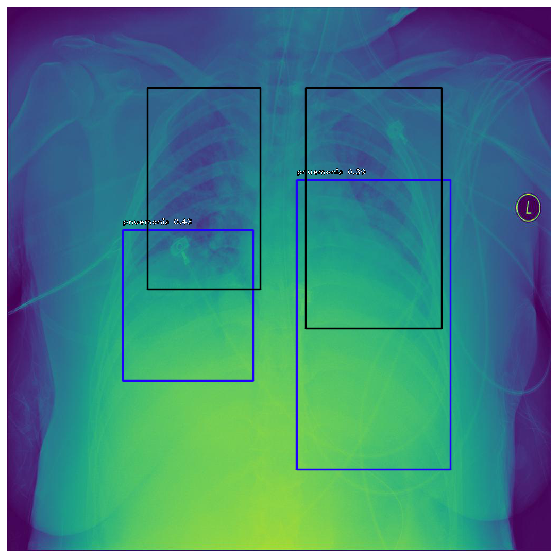

In [72]:
#Black Boxes - Actual
#Blue Boxes  - Predicted
THRES_SCORE =0.3
patient_id='00436515-870c-4b36-a041-de91049b9ab4'
draw_image(patient_id)

Mean_IOU::0.2838316182858208


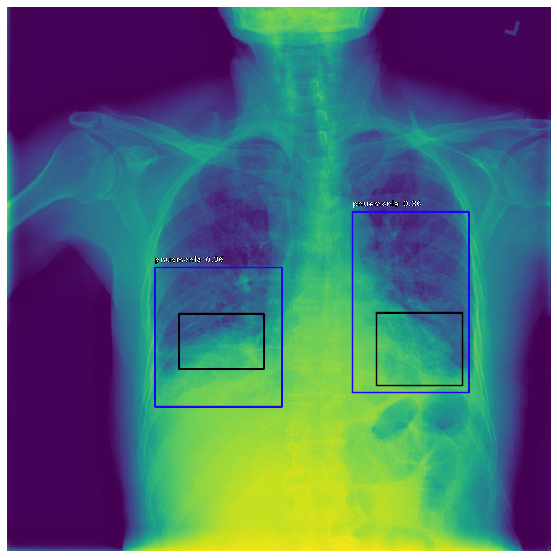

In [73]:
THRES_SCORE =0.3
patient_id='00704310-78a8-4b38-8475-49f4573b2dbb'
draw_image(patient_id)

Mean_IOU::0.0


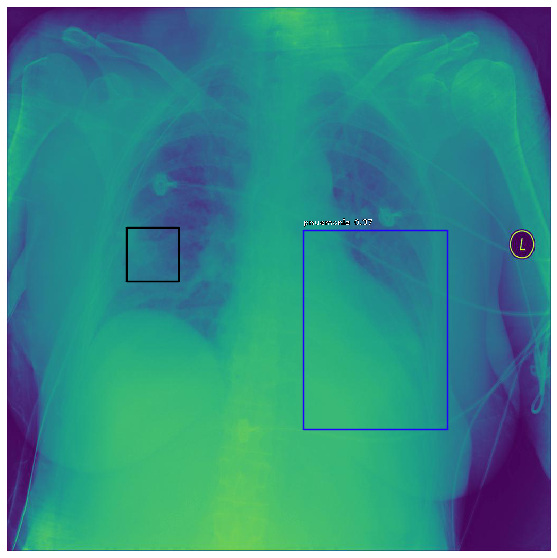

In [80]:
THRES_SCORE =0.36
patient_id='01adfd2f-7bc7-4cef-ab68-a0992752b620'
draw_image(patient_id)

Mean_IOU::0.13748240575189258


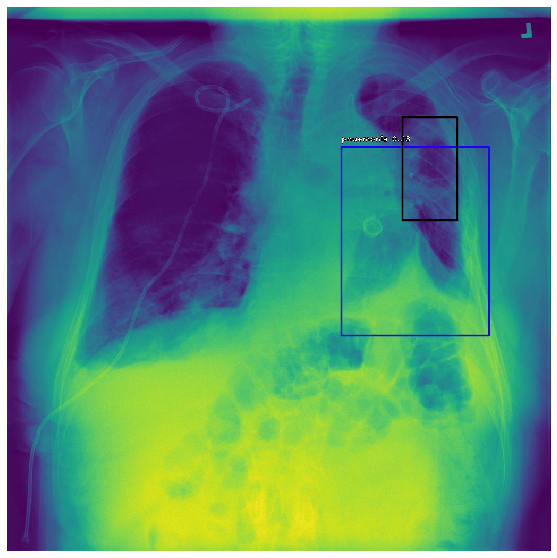

In [91]:
THRES_SCORE =0.2755
patient_id='02285fa4-35b7-4af6-b88f-3cac45a7f5c8'
draw_image(patient_id)

Conclusion

In [0]:
# Based on 10 epochs the MAP comes to 0.23 and it looks promising for further analysis